/tmp/ipykernel_60266/3048202086.py:52: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bbox = stays_geo.buffer(1).total_bounds


<AxesSubplot:>

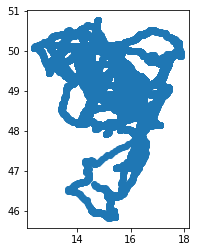

In [5]:
'''
02_travel.ipynb
Calculate metrices for travel
'''

import pathlib
import os
import pandas as pd
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point, Polygon, LineString, MultiPoint
import geojson
import h3
import swifter
import matplotlib.pyplot as plt
import matplotlib
from colormap import rgb2hex

import seaborn as sns
import folium

# needs for projections
from pyproj import CRS
crs=CRS('EPSG:4326')

DIR_ROOT = os.path.join(pathlib.Path().absolute(), '../../../' )
DIR_DATA = DIR_ROOT + '/data/04_itinerary/'
DIR_OUT = DIR_ROOT + '/data/05_metrics/'
os.makedirs(DIR_OUT) if not os.path.exists(DIR_OUT) else False

activities_df = pd.read_csv(DIR_DATA + 'activities.csv')

stays_df = pd.read_csv(DIR_DATA + 'stays.csv')
stays_df = stays_df[stays_df['domestic'] == True]
stays_df['geometry'] = stays_df['geometry'].apply(wkt.loads)
stays_df.set_index('locality', inplace=True)

stays_geo = gpd.GeoDataFrame(stays_df, crs=crs, columns=['geometry']).set_geometry('geometry')
localities = stays_geo.groupby(level=0).first()
localities['name'] = localities.index

positions_df = pd.read_csv(DIR_DATA + 'positions.csv')
positions_df = positions_df[positions_df['domestic'] == True]
positions_df['geometry'] = positions_df['geometry'].apply(wkt.loads)
positions_geo = gpd.GeoDataFrame(positions_df, crs=crs).set_geometry('geometry')

tiles = {
  	"url": "https://{s}.tile.openstreetmap.org/{z}/{-x}/{y}.png", 
	"attribution": '',
}

bbox = stays_geo.buffer(1).total_bounds
bounds = dict(geojson.Polygon([[[bbox[0], bbox[1]], [bbox[0], bbox[3]], [bbox[2], bbox[3]], [bbox[2], bbox[1]]]]))
hex_ids = list(h3.polyfill(bounds, 5))

hex_df = gpd.GeoDataFrame(
    [{"geometry": Polygon(h3.h3_to_geo_boundary(x)), "id": x} for x in hex_ids], crs='epsg:4326'
)
hex_df.set_index('id', inplace=True)

def create_map():
    m = folium.Map(tiles='Stamen Toner', dragging=False, zooming=False)

    m.fit_bounds([[bbox[1], bbox[0]], [bbox[3], bbox[2]]])
    return m

def create_circle(radius, geometry, tooltip):
    return folium.CircleMarker(
        radius=radius,
        location=[geometry.y, geometry.x], 
        tooltip=tooltip,   
        weight=1,
        color="red",
        fill="red",
    )

positions_geo.plot()

In [ ]:
pos_travel = positions_geo[positions_geo['traveling'] == True]
pos_stay = positions_geo[positions_geo['traveling'] == False]

hex4_ids = list(h3.polyfill(bounds, 4))

hexes_ratio = gpd.GeoDataFrame(
    [{"geometry": Polygon(h3.h3_to_geo_boundary(x)), "id": x} for x in hex4_ids], crs=crs
)
hexes_ratio.set_index('id', inplace=True)

hexes_ratio['travel'] = hexes_ratio.swifter.apply(
    lambda x: len(pos_travel[pos_travel['geometry'].intersects(x['geometry'])]),
    axis=1
)

hexes_ratio['stay'] = hexes_ratio.swifter.apply(
    lambda x: len(pos_stay[pos_stay['geometry'].intersects(x['geometry'])]),
    axis=1
)

hexes_ratio['diff'] = hexes_ratio['stay'] - hexes_ratio['travel']

hexes_ratio['centroid'] = hexes_ratio.swifter.apply(
    lambda x: Point(h3.h3_to_geo(x.name)),
    axis=1
)

hexes_ratio_df = pd.DataFrame(hexes_ratio) 
hexes_ratio_df.to_csv(DIR_ROOT + '/data/06_outputs/travel_ratio.csv')

In [ ]:
hexes_ratio_df = pd.DataFrame(hexes_ratio) 
hexes_ratio_df.to_csv(DIR_ROOT + '/data/06_outputs/travel_ratio.csv')

In [ ]:
# density of all domestic locations
hexes_all = gpd.GeoDataFrame(
    gpd.sjoin(hex_df.copy(), positions_geo, how="left", op="contains").index.value_counts()
)
hexes_all.columns = ['freq']
hexes_all['id'] = hexes_all.index
hexes_all['geometry'] = hexes_all.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x['id'])), axis=1)
hexes_all.set_crs(crs)

m = create_map()

cmap = matplotlib.cm.get_cmap('afmhot_r')
norm = matplotlib.colors.SymLogNorm(linthresh = 1, vmin = 0, vmax = 100000)

for i, hex in hexes_all.iterrows():
    coords = [[p[1], p[0]] for p in list(hex['geometry'].exterior.coords)]
    folium.Polygon(
       locations=coords,
       fill=True,
       stroke=False,
       fill_opacity=0 if hex['freq'] == 1 else 0.7,
       fill_color=rgb2hex(*cmap(norm(hex['freq'])))
    ).add_to(m)
m

In [ ]:
# density of all domestic locations where POII was traveling
hexes_travel = gpd.GeoDataFrame(
    gpd.sjoin(hex_df.copy(), positions_geo[positions_geo['traveling'] == True], how="left", op="contains").index.value_counts(), 
)

hexes_travel.columns = ['freq']
hexes_travel['id'] = hexes_travel.index
hexes_travel['geometry'] = hexes_travel.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x['id'])), axis=1)
hexes_all.set_crs(crs)

m = create_map()

cmap = matplotlib.cm.get_cmap('afmhot_r')
norm = matplotlib.colors.SymLogNorm(linthresh = 1, vmin = 0, vmax = 1000)

for i, hex in hexes_travel.iterrows():
    coords = [[p[1], p[0]] for p in list(hex['geometry'].exterior.coords)]
    folium.Polygon(
       locations=coords,
       fill=True,
       stroke=False,
       fill_opacity=0 if hex['freq'] == 1 else 0.7,
       fill_color=rgb2hex(*cmap(norm(hex['freq'])))
    ).add_to(m)
m

In [ ]:
# number of hours PO2 stayed in every location and within each period
localities['stay_pall'] = localities.apply(
    lambda x: len(positions_df[(positions_df['stay_location'] == x['name']) & (positions_df['traveling'] == False)]), axis = 1
)
localities['stay_p1'] = localities.apply(
    lambda x: len(positions_df[(positions_df['period'] == 1) & (positions_df['stay_location'] == x['name'])  & (positions_df['traveling'] == False)]), axis = 1
)
localities['stay_p2'] = localities.apply(
    lambda x: len(positions_df[(positions_df['period'] == 2) & (positions_df['stay_location'] == x['name']) & (positions_df['traveling'] == False)]), axis = 1
)
localities['stay_p3'] = localities.apply(
    lambda x: len(positions_df[(positions_df['period'] == 3) & (positions_df['stay_location'] == x['name']) & (positions_df['traveling'] == False)]), axis = 1
)
localities['stay_p4'] = localities.apply(
    lambda x: len(positions_df[(positions_df['period'] == 4) & (positions_df['stay_location'] == x['name']) & (positions_df['traveling'] == False)]), axis = 1
)
localities['stay_p5'] = localities.apply(
    lambda x: len(positions_df[(positions_df['period'] == 5) & (positions_df['stay_location'] == x['name']) & (positions_df['traveling'] == False)]), axis = 1
)

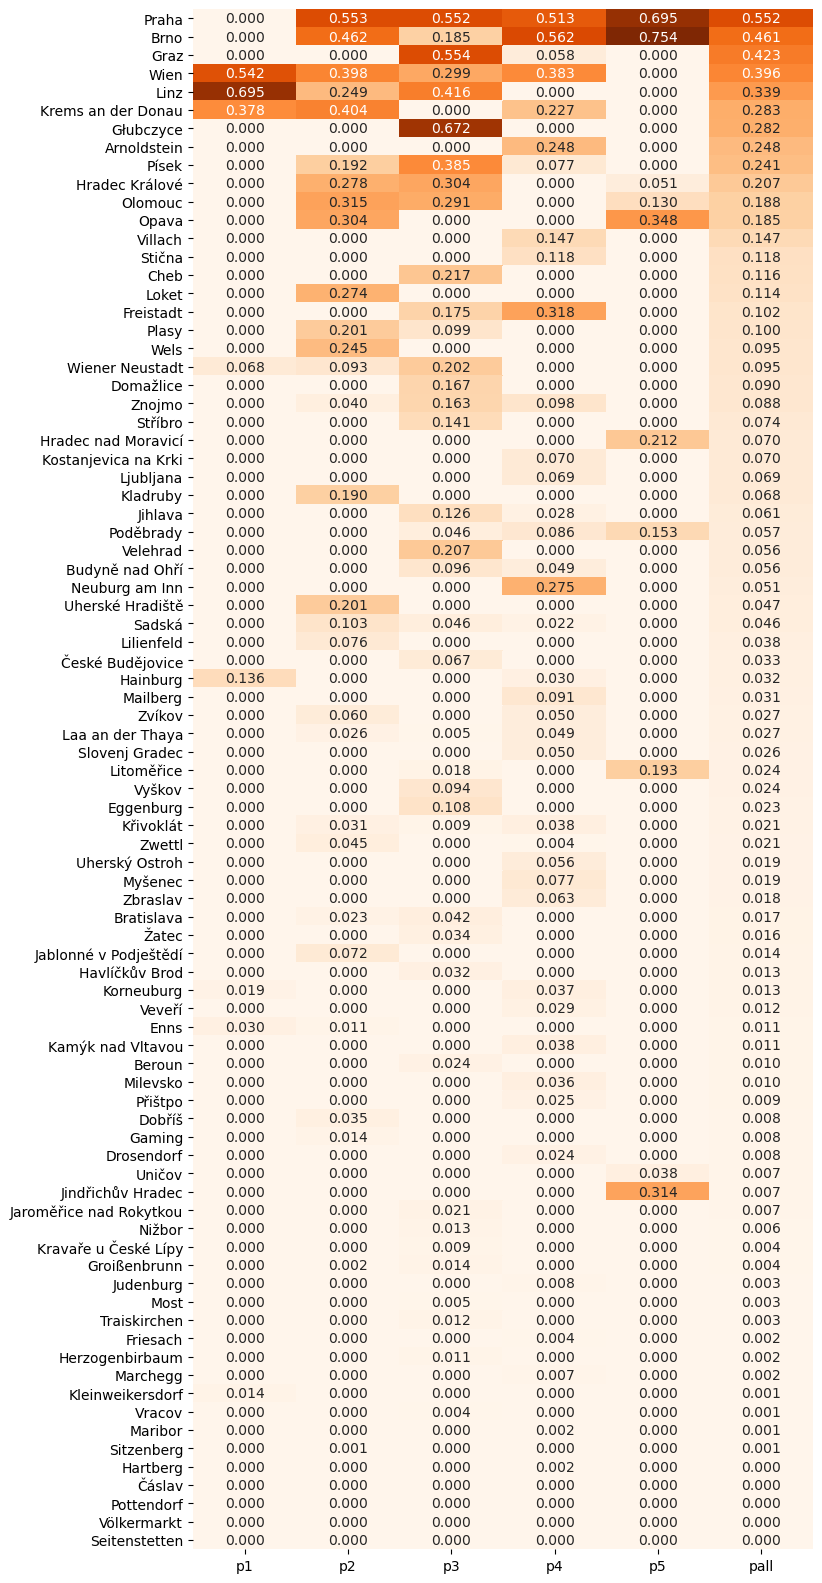

In [130]:
# calculate buffers for various kilometer distances
localities.set_crs(crs, inplace=True)
localities['geometry_m'] = localities['geometry'].to_crs("EPSG:5514")
localities['b_1'] = localities['geometry_m'].buffer(500).to_crs(crs)
localities['b_30'] = localities['geometry_m'].buffer(30000).to_crs(crs)
localities['b_60'] = localities['geometry_m'].buffer(60000).to_crs(crs)
localities['b_120'] = localities['geometry_m'].buffer(90000).to_crs(crs)
localities['b_240'] = localities['geometry_m'].buffer(120000).to_crs(crs)

localities = localities.to_crs(crs)

#localities['b_240'].plot()

plt.show()

In [131]:
'''
Travel coefficient
'''

periods = ['1', '2', '3', '4', '5', 'all']
travel_coeffs = {}

weight_30 = 1
weight_60 = 0.75
weight_120 = 0.5
weight_240 = 0.25

dfs = []

for period in periods:
    positions_period = positions_geo[positions_geo['period'] == int(period)] if period != 'all' else positions_geo

    loc_1 = gpd.GeoDataFrame(
        gpd.sjoin(
            gpd.GeoDataFrame(localities, geometry='b_1', crs=crs), 
            positions_period, 
            how="left", 
            op="contains"
        ).index.value_counts() - 1, 
        crs=crs
    )

    loc_30 = gpd.GeoDataFrame(
        gpd.sjoin(
            gpd.GeoDataFrame(localities, geometry='b_30', crs=crs),
            positions_period, 
            how="left", 
            op="contains"
        ).index.value_counts() - 1, 
        crs=crs
    ).subtract(loc_1)

    loc_60 = gpd.GeoDataFrame(
        gpd.sjoin(
            gpd.GeoDataFrame(localities, geometry='b_60', crs=crs),
            positions_period, 
            how="left", 
            op="contains"
        ).index.value_counts() - 1, 
        crs=crs
    ).subtract(loc_30)

    loc_120 = gpd.GeoDataFrame(
        gpd.sjoin(
            gpd.GeoDataFrame(localities, geometry='b_120', crs=crs),
            positions_period, 
            how="left", 
            op="contains"
        ).index.value_counts() - 1, 
        crs=crs
    ).subtract(loc_60)

    loc_240 = gpd.GeoDataFrame(
        gpd.sjoin(
            gpd.GeoDataFrame(localities, geometry='b_240', crs=crs),
            positions_period, 
            how="left", 
            op="contains"
        ).index.value_counts() - 1, 
        crs=crs
    ).subtract(loc_120)

    df = loc_1 / (loc_30 * weight_30 + loc_60 * weight_60 + loc_120 * weight_120 + loc_240 * weight_240)
    df.columns = ['p' + period]
    dfs.append(df)

    print('p{} processed'.format(period))


travel_coeffs = gpd.GeoDataFrame(
    pd.concat(dfs + [localities['geometry']], axis=1, join="outer"),
    crs=crs
)

travel_coeffs = travel_coeffs.fillna(0)
travel_coeffs.to_csv(DIR_OUT + 'travel.csv')

p1 processed
p2 processed
p3 processed
p4 processed
p5 processed
pall processed


In [128]:
travel_coeffs.sort_values(by='pall',ascending=False, inplace=True)
fig, ax = plt.subplots(figsize = (8, 20)) 
sns.heatmap(travel_coeffs[['p1', 'p2', 'p3', 'p4', 'p5', 'pall']], cmap ='Oranges', annot = True, cbar=False, fmt=".3f")

<AxesSubplot:>

In [129]:
map = create_map()

for location_name, r in travel_coeffs.iterrows():
    create_circle(
        r['pall'] *20 + 3, r['geometry'], 
        '{}: {}'.format(location_name, r['pall'])
    ).add_to(map)
map